Libraries
=

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.losses import MeanSquaredLogarithmicError

Noiser
=

In [109]:
def noiser(data,noise_factor=1.5):
    noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape).astype(np.float32)#loc=mean,scale=std
    data = data + noise_factor*noise
    data = np.clip(data, 0., 1.)
    return data

Data loader
=

In [110]:
def load_noisy_dataset(directory, batch_size):
    datagen = ImageDataGenerator(rescale=1./255)  # Normalize to range [0, 1]
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),# Adjust based on your needs
        batch_size=batch_size,
        class_mode=None,
        shuffle=True
    )
    for batch in generator:
        noisy_batch = noiser(batch)
        yield noisy_batch, batch

Load data
=

In [111]:
train_dir = 'D:/MO3 LAP/Datasets/Birds_525_Species/train'
test_dir = 'D:/MO3 LAP/Datasets/Birds_525_Species/test'  
val_dir = 'D:/MO3 LAP/Datasets/Birds_525_Species/valid' 

batch_size=32

x_train_noisy = load_noisy_dataset(train_dir, batch_size)
x_test_noisy = load_noisy_dataset(test_dir, batch_size)
x_val_noisy = load_noisy_dataset(val_dir, batch_size)

Define models
=

In [95]:
# Define convolutional block
def conv_block(x, filters, kernel_size, strides=2):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

# Define deconvolutional block
def deconv_block(x, filters, kernel_size):
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

# Define the encoder
def build_encoder(input_shape):
    inputs = Input(shape=input_shape)

    x = conv_block(inputs, 32, 3)
    x = conv_block(x, 64, 3)
    x = conv_block(x, 128, 3)
    x = conv_block(x, 256, 3)
    x = conv_block(x, 512, 3)  # Additional layer
    #x = conv_block(x, 3, 3)  # Additional layer

    return Model(inputs, x, name='encoder')

# Define the decoder
def build_decoder(output_shape):
    inputs = Input(shape=output_shape)

   #x = deconv_block(inputs, 512, 3)  # Additional layer
    x = deconv_block(inputs, 256, 3)  # Additional layer
    x = deconv_block(x, 128, 3)
    x = deconv_block(x, 64, 3)
    x = deconv_block(x, 32, 3)
    x = deconv_block(x, 3, 3)  # 3 channels for RGB images

    return Model(inputs, x, name='decoder')

# Define the autoencoder
def build_autoencoder(input_shape):
    encoder = build_encoder(input_shape)
    decoder = build_decoder(encoder.output_shape[1:])

    inputs = Input(shape=input_shape)

    encoded = encoder(inputs)
    decoded = decoder(encoded)

    autoencoder = Model(inputs, decoded, name='autoencoder')
    return encoder,decoder,autoencoder


Some parameters
=

In [16]:
num_train_images = 84635  # replace with the actual number of training images you have
batch_size = 32
steps_per_epoch = num_train_images // batch_size

Train AutoEncoder
=

In [97]:
input_shape = (224, 224, 3)  
encoder4,decoder4,autoencoder4 = build_autoencoder(input_shape)
autoencoder4.compile(optimizer=Adam(learning_rate=0.094), loss=MeanSquaredLogarithmicError(),metrics='accuracy')
autoencoder4.fit(x_train_noisy, epochs = 5, steps_per_epoch = steps_per_epoch, validation_data = x_val_noisy, validation_steps = 80)

Found 84635 images belonging to 525 classes.
Epoch 1/5
2644/2644 [==============================] - 303s 114ms/step - loss: 0.0069 - accuracy: 0.4717 - val_loss: 0.0048 - val_accuracy: 0.6274
Epoch 2/5
2644/2644 [==============================] - 304s 115ms/step - loss: 0.0036 - accuracy: 0.6500 - val_loss: 0.0049 - val_accuracy: 0.7676
Epoch 3/5
2644/2644 [==============================] - 326s 123ms/step - loss: 0.0028 - accuracy: 0.7912 - val_loss: 0.0058 - val_accuracy: 0.8084
Epoch 4/5
2644/2644 [==============================] - 398s 151ms/step - loss: 0.0025 - accuracy: 0.7969 - val_loss: 0.0026 - val_accuracy: 0.7466
Epoch 5/5
2644/2644 [==============================] - 326s 123ms/step - loss: 0.0024 - accuracy: 0.7995 - val_loss: 0.0030 - val_accuracy: 0.8402


In [115]:
autoencoder4.fit(x_train_noisy, epochs=5, steps_per_epoch=steps_per_epoch, validation_data=x_val_noisy, validation_steps=80)

Found 84635 images belonging to 525 classes.
Epoch 1/5
2644/2644 [==============================] - 355s 134ms/step - loss: 0.0025 - accuracy: 0.7960 - val_loss: 0.0029 - val_accuracy: 0.7557
Epoch 2/5
2644/2644 [==============================] - 388s 147ms/step - loss: 0.0023 - accuracy: 0.7976 - val_loss: 0.0027 - val_accuracy: 0.8051
Epoch 3/5
2644/2644 [==============================] - 416s 157ms/step - loss: 0.0023 - accuracy: 0.7972 - val_loss: 0.0022 - val_accuracy: 0.7322
Epoch 4/5
2644/2644 [==============================] - 323s 122ms/step - loss: 0.0023 - accuracy: 0.7953 - val_loss: 0.0025 - val_accuracy: 0.8008
Epoch 5/5
2644/2644 [==============================] - 306s 116ms/step - loss: 0.0022 - accuracy: 0.7996 - val_loss: 0.0035 - val_accuracy: 0.8286


Save AutoEncoder
=

In [128]:
autoencoder4.save('D:/MO3 LAP/GAN/assignment 3/models/autoencoder4.h5')  

Test AutoEncoder
=

In [117]:
noisy_images,original_images, = next(x_test_noisy)
encoded_images = encoder4.predict(original_images)
decoded_images = decoder4.predict(encoded_images)



1/1 [==============================] - 0s 20ms/step


Look at some shapes
=

In [118]:
print(original_images.shape)
print(noisy_images.shape)
print(encoded_images.shape)
print(decoded_images.shape)

(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 7, 7, 512)
(32, 224, 224, 3)


Plot results
=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


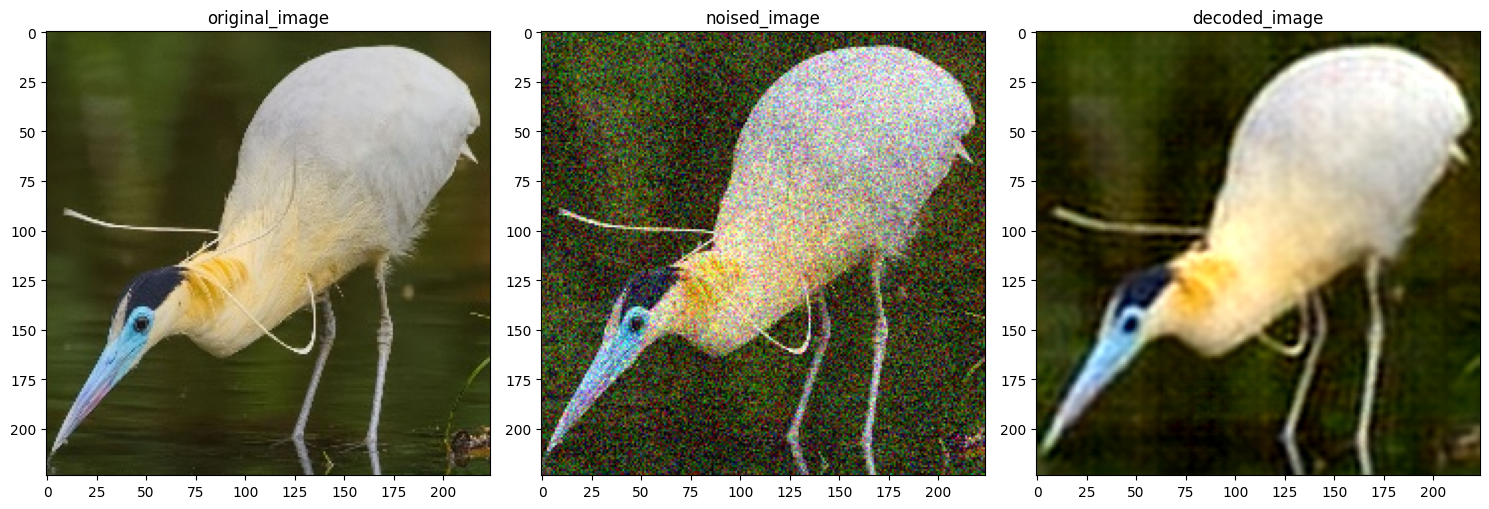

In [127]:

# Set the figure size
plt.figure(figsize=(15, 5))  # Adjust the width and height as needed

# Plot the first image
plt.subplot(131)  # 1 row, 3 columns, first subplot
plt.imshow(original_images[0])
plt.title('original_image')

# Plot the second image
plt.subplot(132)  # 1 row, 3 columns, second subplot
plt.imshow(noisy_images[0])
plt.title('noised_image')

# Plot the third image
plt.subplot(133)  # 1 row, 3 columns, third subplot
plt.imshow(decoded_images[0])
plt.title('decoded_image')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
